In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)
wq_df['Sampling Location'] = wq_df['Sampling Location'].astype('category')

Having graph showing overlapping failures does not give me additional information on when sites fail in respect to each other. The most highly connected sites in the graph are also the most frequent ones that fail which makes sense. I want to now make a new dataframe that illustrates these connections more completely.

In [2]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [3]:
chl_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_chl'
    site_list = site_fail_col(wq_df, site, 'Top Active Chlorophyll \'A\' (µg/L)')
    
    chl_overlap_df[col_name] = site_list

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


For these graphs, the site along the x-axis is the one who's prediction ability we are testing. If site_x fails, then what is the probability that site_y fails too. I made it so the sum of each row and column had to be greater than 1 so if site_x fails, at least 1 of the shown sites should fail as well.

(16, 26)


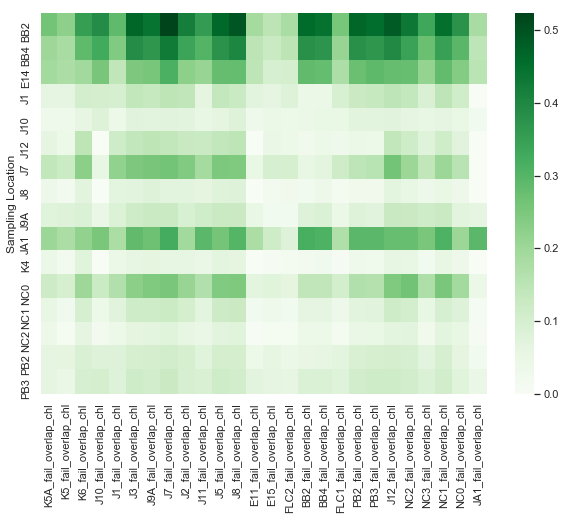

In [4]:
chl_means_df = chl_overlap_df.groupby('Sampling Location').mean()
for i, row in chl_means_df.iterrows():
    if row.sum() <= 1:
        chl_means_df = chl_means_df.drop(index=[i])

for col in chl_means_df:
    if chl_means_df[col].sum() <= 1:
        chl_means_df = chl_means_df.drop(columns=[col])
        
print(chl_means_df.shape)    
_ = plt.figure(figsize=(10, 7))
_ = sns.heatmap(data=chl_means_df, cmap='Greens')

With the above heatmaps, I am able to see which sites I should focus my efforts on. For instance in the chlorophyll heatmap (green), J11 appears to have a relationship to a variety of sites. I will explore this later as well.

# Inverse Distance Weighted Maps

It will be helpful for my analysis to put the heatmaps in the context of geography. For the following graphs, I took into account the distance between each site using latitude and longitude as well as the frequency of overlap. In following Tobler's First Law of Geography, sites that are closer together will have a greater likelihood of influencing each other. 

The following function was repurposed from [this](https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python) Stack Overflow thread.


In these visualizations, the darkest areas are the sites that predict a failure at the target site.

In [5]:
def main(df, site, param):
    # Setup: Generate data...
    nx, ny = 50, 50
    x = df['Long']
    y = df['Lat']
    z = df[site + '_fail_overlap_' + param]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)
    grid1 = grid1.reshape((nx, ny))

    # Select color for graphs
    if param == 'chl':
        color = 'Greens'
    elif param == 'ent':
        color = 'Reds'
    elif param == 'pho':
        color = 'Blues'
    # Comparisons...
    if sum(z) > 0:
        site_info = df[df.index == site]
        plot(x,y,z,grid1,color)
        plt.title('Heatmap Indicating Sites Overlapping with ' + site, 
                  fontsize=18)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(x=site_info['Long'], y=site_info['Lat'],
                    marker='o', c='r', s=100, label=site)
        plt.legend()
        plt.show()

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid,color):
    
    plt.figure(figsize=(12,9))
    plt.tight_layout()
    plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
               cmap=color)
    plt.colorbar()

Next I want to create each parameter's joined dataframe using the overlap dataframes I created previously. These will be used to produce the IDW graphs.

In [6]:
lat = wq_df.groupby('Sampling Location')['Lat'].mean()
long = wq_df.groupby('Sampling Location')['Long'].mean()

chl_df = chl_overlap_df.groupby('Sampling Location').mean()
chl_joined_df = chl_df.join(lat)
chl_joined_df = chl_joined_df.join(long)

## Chlorophyll

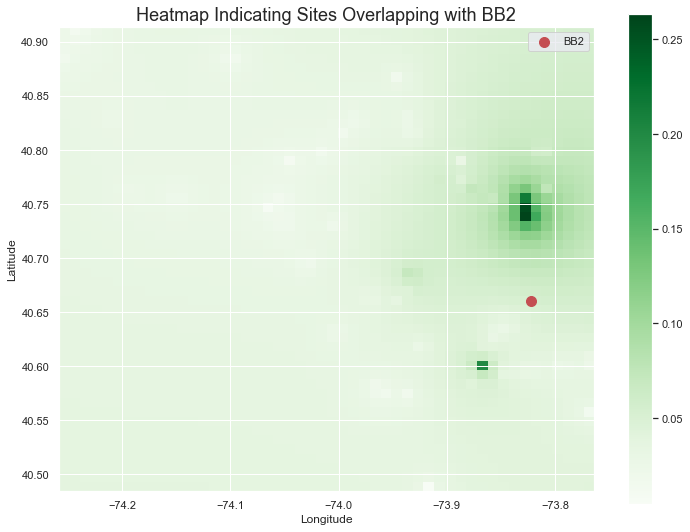

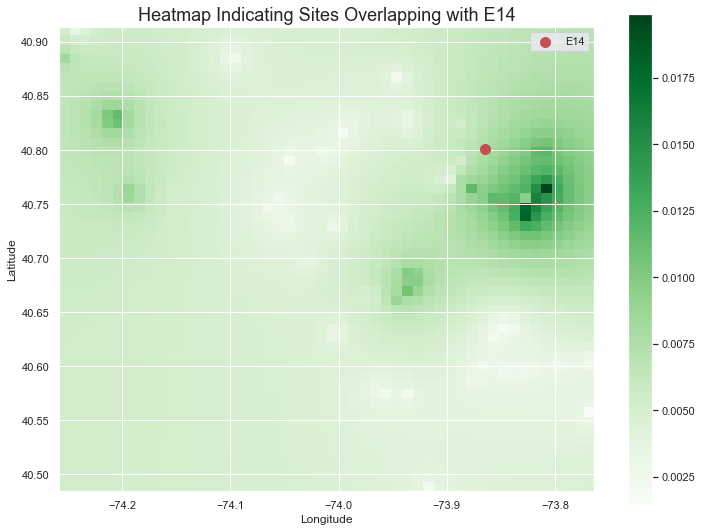

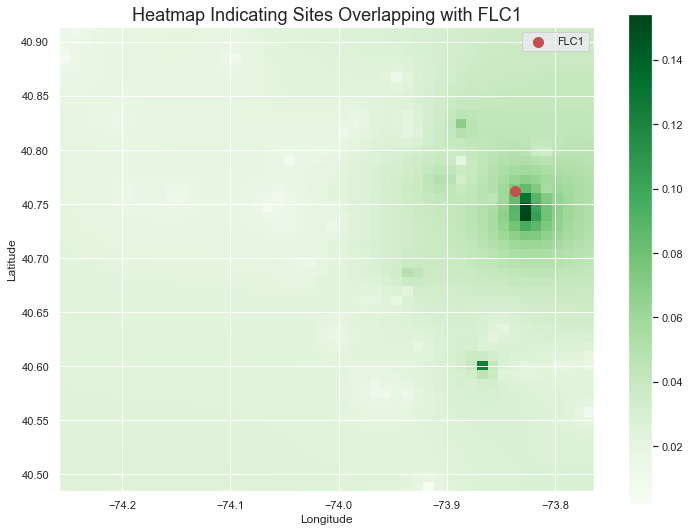

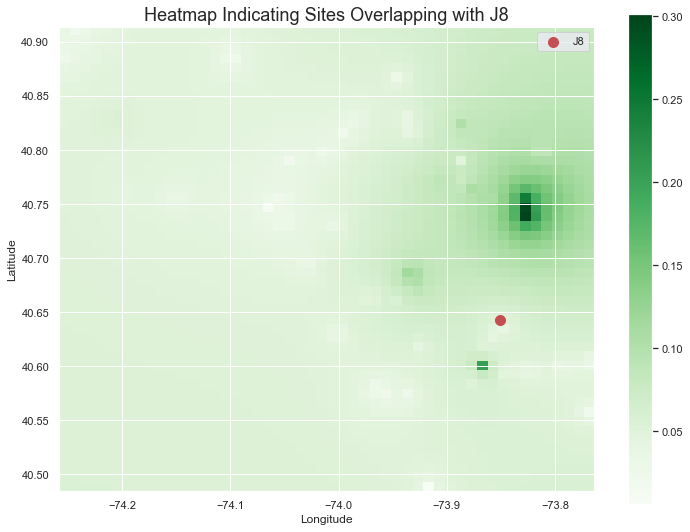

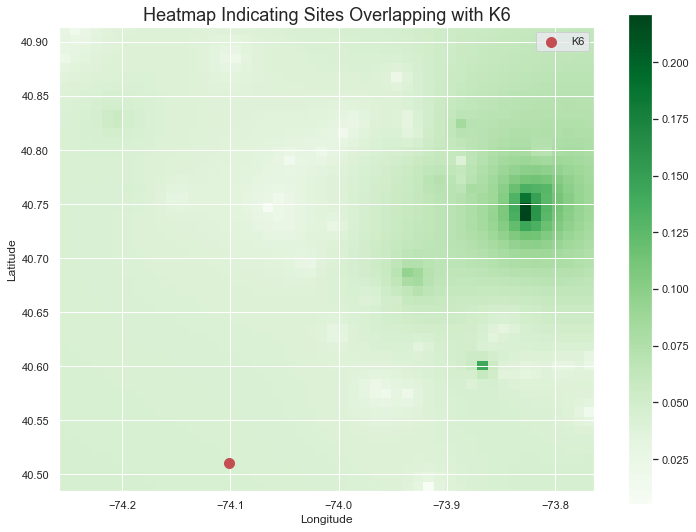

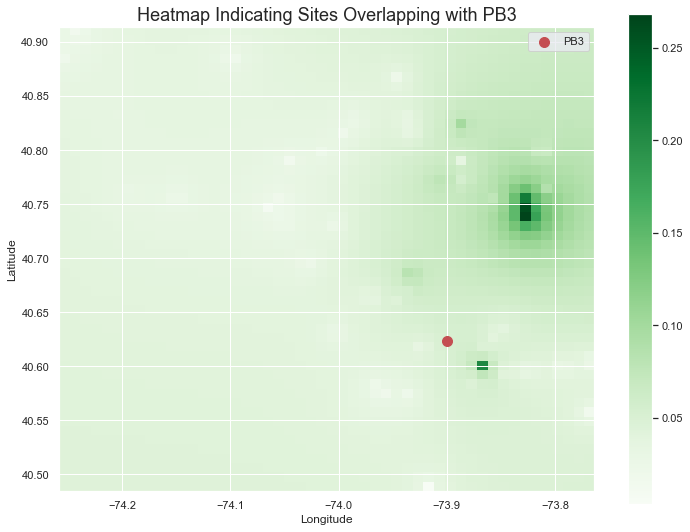

In [7]:
sites = ['BB2', 'E14', 'FLC1',
         'J8', 'K6', 'PB3']

for site in sites:
    main(chl_joined_df, site, 'chl')
    

# Choosing Sites to Investigate Further

In order determine which sites to target as predictors of quality elsewhere, I will look at a few different features of the heatmaps. The following ar in no particular order and are meant to be used in conjunction with each other.

- **Map Scale**
    If the maximum on the color bar is above 0.1, then I believe that the site may have good prediction power.

- **Geography** 
    If a site is far away from the sites where it has fairly high overlap, then I believe it is reasonable that these overlaps are more anomalous than caused by the actual flow of water between sites.

- **Overall Overlap**
    If a site overlaps with a lot of other sites, it may be worthwhile to investigate whether this site could predict for a large swath of sites at once. If it proved successful, then it could be a huge time/money saver for state agencies performing sampling.
    

## Sites for Further Investigation

These sites appear to have high predictability for each parameter. Some are greater than others, but this variation will show me gradiations in the effectiveness of the model.

### Site List

- `BB2`, `E14`, `FLC1`, `J8`, `K6`, `PB3`



I am going to work through these systematically. I will showcase the full process first and show fewer steps for later sites.

# Model Selection and Testing

To create my dataframe, I need to combine `wq_df` with the columns showing overlap in failures for each site I am investigating further.

In [8]:
chl_class_df = wq_df.join(chl_overlap_df.loc[:, ['BB2_fail_overlap_chl',
                                                 'E14_fail_overlap_chl', 
                                                 'FLC1_fail_overlap_chl', 
                                                 'J8_fail_overlap_chl',
                                                 'K6_fail_overlap_chl',
                                                 'PB3_fail_overlap_chl']])

## Data Preparation

### Resampling
All of the target variables I am working with are heavily imbalanced, so I need to have a way to fix this issue. The following function resamples so there are 2000 data of each target class. Since there are ~1000 positive responses in the entire dataset, I did not feel comfortable that upsampling the positive responses to ~20,000 would be an accurate representation of the data, and downsampling the negative responses to ~1000 would leave me with very few data points. I decided on a middle ground of 4000 of each.

In [9]:
def balance(df, site):
    '''Resamples dataset to balance target variable categorizations.
       Input df must be ML model ready meaning there are no object
       columns etc.'''
    
    target = site + '_fail_overlap_chl'
    
    
    class0 = df[df[target] == 0]
    class1 = df[df[target] == 1]
    nclass0 = len(class0)
    nclass1 = len(class1)
    class0_resampled = np.random.choice(class0.index, size=4000, replace=True)
    class1_resampled = np.random.choice(class1.index, size=4000, replace=True)
    try:
        resampled_df = df.iloc[class0_resampled]
        resampled_df = resampled_df.append(df.iloc[class1_resampled])
    except:
        resampled_df = df.loc[class0_resampled]
        resampled_df = resampled_df.append(df.iloc[class1_resampled])
    return resampled_df

## BB2
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [10]:
from sklearn.model_selection import train_test_split

BB2_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
BB2_chl_int_df = BB2_chl_int_df.drop(columns=['Lat', 'Long'])
BB2_chl_int_df = BB2_chl_int_df[chl_class_df['Sampling Location'] != 'BB2']

features = BB2_chl_int_df.iloc[:, :38].copy()
target = BB2_chl_int_df.loc[:, 'BB2_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_BB2_df = balance(BB2_chl_int_df, 'BB2')

x_train = balanced_BB2_df.iloc[:, :38]
target_train = balanced_BB2_df.loc[:, 'BB2_fail_overlap_chl']

## Feature Selection

In order to select my features, |I will perform Recursive Feature Elimination (RFE). RFE ranks the features and eliminates the worst predictors. First it is trained on the initial set of features and then it eliminates more based on the coef_ or feature_importances_ attribute. I will use an out-of-the-box

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

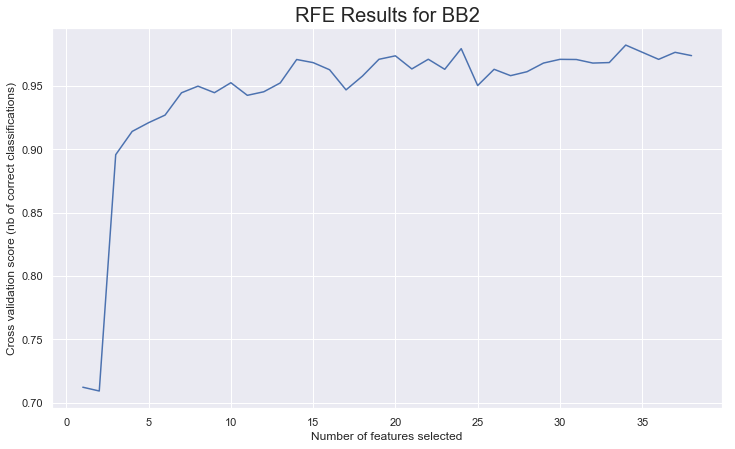

In [12]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for BB2', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [13]:
from sklearn.feature_selection import RFE

selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [14]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

The three classification models I am going to use are I am going to test are Random Forest Classifier, Logistic Regression, and XGBoost.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost as xgb

rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'Precision: ', precision_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier Precision:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6864
           1       0.89      0.58      0.70       207

    accuracy                           0.99      7071
   macro avg       0.94      0.79      0.85      7071
weighted avg       0.98      0.99      0.98      7071

[[6849   15]
 [  87  120]] 

LogisticRegression Precision:  0.6045627376425855
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6864
           1       0.60      0.77      0.68       207

    accuracy                           0.98      7071
   macro avg       0.80      0.88      0.83      7071
weighted avg       0.98      0.98      0.98      7071

[[6760  104]
 [  48  159]] 

XGBClassifier Precision:  0.8
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6864
           1       0.80      0.66      0.72  

In [16]:
from sklearn.metrics import auc, precision_recall_curve

precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

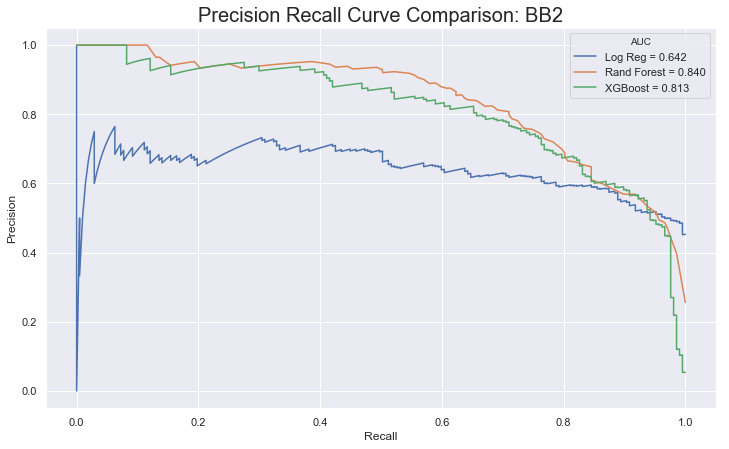

In [17]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: BB2', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

When looking at the different models, I need to consider what type of misclassifications I am willing to live with. The ultimate goal of this model is to save municipalities money on monitoring programs, so a model that produces a high number of true positives as well as false positives like the Logistic Regression model runs counter to this original intent. This narrows my decision down to the Random Forest Classifier and the XGBoost Classifier.


Based on the classification reports, confusion matrices, F1 scores, precision recall curves, and the nature of my problem, I am going to tune the XGBoost model further.

# Hyperparameter Tuning

First I'm going to create a baseline model to work with before tuning to determine the optimum number of trees for the learning rate.

In [18]:
xg_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5,
                             min_child_weight=1, gamma=0,
                            subsample=0.8, colsample_bytree=0.8,
                            scale_pos_weight=1)
xg_model.fit(best_features_train, target_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_child_weight':[1, 5],
              'max_depth':[3, 6, 9],
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                            subsample=0.8, colsample_bytree=0.8)

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 6, 9], 'min_child_weight': [1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [20]:
gscv.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [21]:
param_grid = {'gamma':[i/10 for i in range(0,5)]}
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                             subsample=0.8, colsample_bytree=0.8,
                             max_depth=6, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1'

In [22]:
gscv.best_params_

{'gamma': 0.2}

In [23]:
param_grid = {'subsample':[i/10 for i in range(6,10)],
              'colsample_bytree':[i/10 for i in range(6,10)]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1,
                             max_depth=6, min_child_weight=1,
                             gamma=0.2
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs',

In [24]:
gscv.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.8}

In [25]:
param_grid = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0.2,
                             subsample=0.8, colsample_bytree=0.7,
                             max_depth=6, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='precision')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.7, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [26]:
gscv.best_params_

{'reg_alpha': 0}

In [27]:
xg_model = xgb.XGBClassifier(learning_rate=0.01, gamma=0.2,
                             subsample=0.8, colsample_bytree=0.7,
                             max_depth=6, min_child_weight=1,
                             reg_alpha=0, n_estimators=1000
                            )

xg_model.fit(best_features_train, target_train)
target_pred = xg_model.predict(best_features_test)
probs = xg_model.predict_proba(best_features_test)
print(name, 'Precision: ', precision_score(target_test, target_pred))
print(classification_report(target_test, target_pred))
print(confusion_matrix(target_test, target_pred), '\n')

XGBClassifier Precision:  0.8506493506493507
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6864
           1       0.85      0.63      0.73       207

    accuracy                           0.99      7071
   macro avg       0.92      0.81      0.86      7071
weighted avg       0.98      0.99      0.98      7071

[[6841   23]
 [  76  131]] 



## E14
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [28]:
E14_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
E14_chl_int_df = E14_chl_int_df.drop(columns=['Lat', 'Long'])
E14_chl_int_df = E14_chl_int_df[chl_class_df['Sampling Location'] != 'E14']

features = E14_chl_int_df.iloc[:, :38].copy()
target = E14_chl_int_df.loc[:, 'E14_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_E14_df = balance(E14_chl_int_df, 'E14')

x_train = balanced_E14_df.iloc[:, :38]
target_train = balanced_E14_df.loc[:, 'E14_fail_overlap_chl']

## Feature Selection

In order to select my features, |I will perform Recursive Feature Elimination (RFE). RFE ranks the features and eliminates the worst predictors. First it is trained on the initial set of features and then it eliminates more based on the coef_ or feature_importances_ attribute. I will use an out-of-the-box

In [29]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

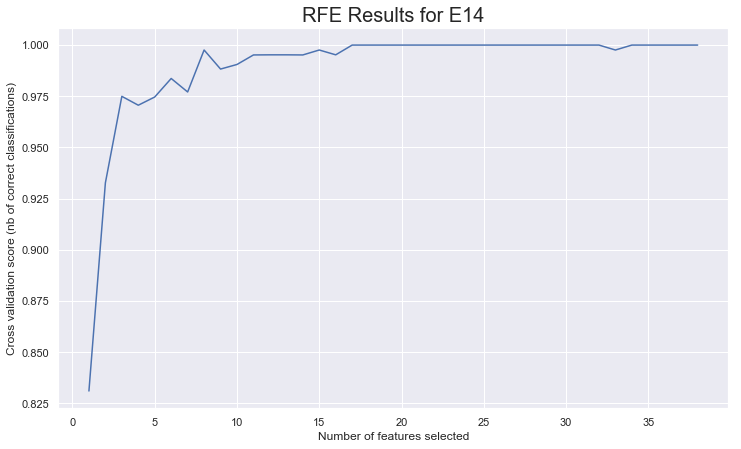

In [30]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for E14', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [31]:
selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [32]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [33]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.42857142857142855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6919
           1       0.92      0.28      0.43        43

    accuracy                           1.00      6962
   macro avg       0.96      0.64      0.71      6962
weighted avg       1.00      1.00      0.99      6962

[[6918    1]
 [  31   12]] 

LogisticRegression F1:  0.3190184049079755
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6919
           1       0.22      0.60      0.32        43

    accuracy                           0.98      6962
   macro avg       0.61      0.80      0.66      6962
weighted avg       0.99      0.98      0.99      6962

[[6825   94]
 [  17   26]] 

XGBClassifier F1:  0.5384615384615383
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6919
           1       0.60      0.49      0.54       

In [34]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

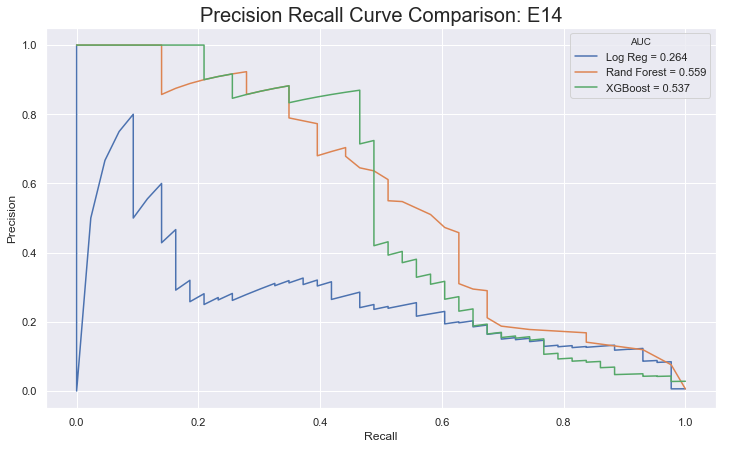

In [35]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: E14', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

This site does not have good predictive power.

## FLC1
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [36]:
FLC1_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
FLC1_chl_int_df = FLC1_chl_int_df.drop(columns=['Lat', 'Long'])
FLC1_chl_int_df = FLC1_chl_int_df[chl_class_df['Sampling Location'] != 'FLC1']

features = FLC1_chl_int_df.iloc[:, :38].copy()
target = FLC1_chl_int_df.loc[:, 'FLC1_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_FLC1_df = balance(FLC1_chl_int_df, 'FLC1')

x_train = balanced_FLC1_df.iloc[:, :38]
target_train = balanced_FLC1_df.loc[:, 'FLC1_fail_overlap_chl']

## Feature Selection

In [37]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

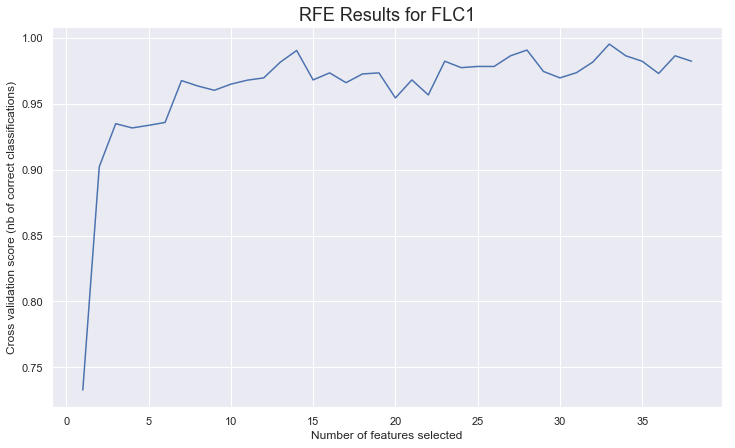

In [38]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for FLC1', fontsize=18)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [39]:
selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [40]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [41]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.18652849740932642
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6866
           1       0.69      0.11      0.19       167

    accuracy                           0.98      7033
   macro avg       0.84      0.55      0.59      7033
weighted avg       0.97      0.98      0.97      7033

[[6858    8]
 [ 149   18]] 

LogisticRegression F1:  0.3880597014925373
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6866
           1       0.39      0.39      0.39       167

    accuracy                           0.97      7033
   macro avg       0.69      0.69      0.69      7033
weighted avg       0.97      0.97      0.97      7033

[[6763  103]
 [ 102   65]] 

XGBClassifier F1:  0.3734439834024897
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6866
           1       0.61      0.27      0.37       

In [42]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

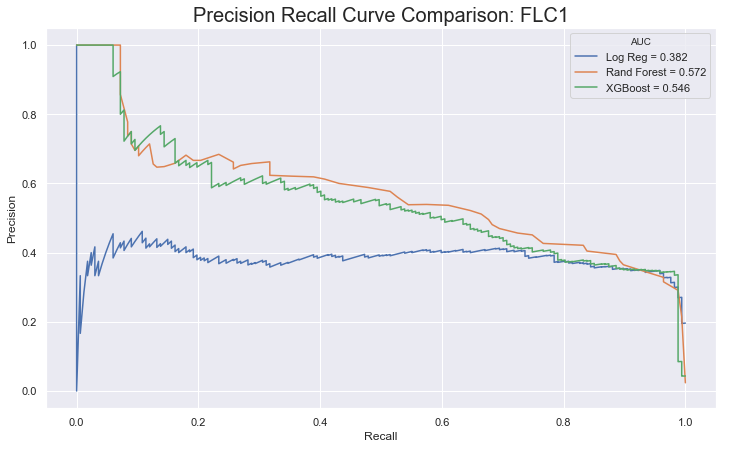

In [43]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: FLC1', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

This site does not have good predictive power.

# J8
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [44]:
J8_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
J8_chl_int_df = J8_chl_int_df.drop(columns=['Lat', 'Long'])
J8_chl_int_df = J8_chl_int_df[chl_class_df['Sampling Location'] != 'J8']

features = J8_chl_int_df.iloc[:, :38].copy()
target = J8_chl_int_df.loc[:, 'J8_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_J8_df = balance(J8_chl_int_df, 'J8')

x_train = balanced_J8_df.iloc[:, :38]
target_train = balanced_J8_df.loc[:, 'J8_fail_overlap_chl']

## Feature Selection

In [45]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

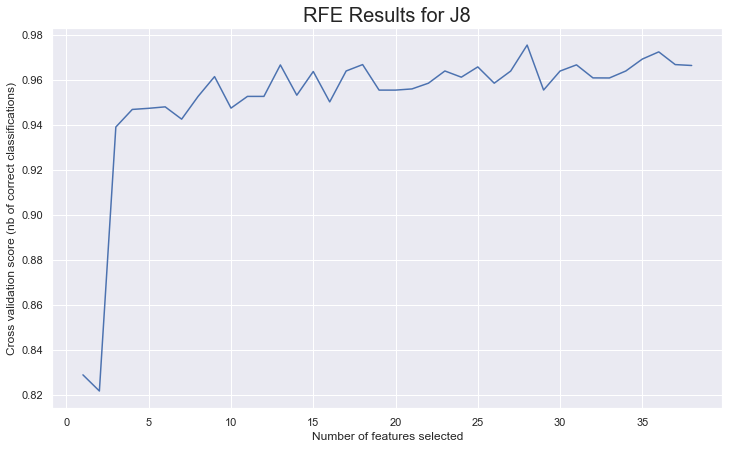

In [46]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for J8', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am not going to drop any of the features.

In [47]:
best_features_train = x_train.copy()
best_features_test = x_test.copy()

## Take binary overlap results and predict other locations

In [48]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.7779527559055118
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6603
           1       0.95      0.66      0.78       374

    accuracy                           0.98      6977
   macro avg       0.96      0.83      0.88      6977
weighted avg       0.98      0.98      0.98      6977

[[6589   14]
 [ 127  247]] 

LogisticRegression F1:  0.8330995792426367
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6603
           1       0.88      0.79      0.83       374

    accuracy                           0.98      6977
   macro avg       0.93      0.89      0.91      6977
weighted avg       0.98      0.98      0.98      6977

[[6561   42]
 [  77  297]] 

XGBClassifier F1:  0.8384279475982532
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6603
           1       0.92      0.77      0.84       3

In [49]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

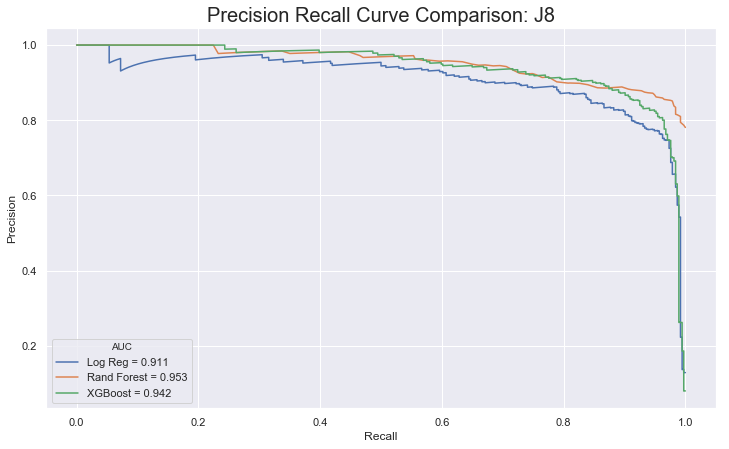

In [50]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: J8', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results

This site has excellent predictive power, so I will tune the model further.

# Hyperparameter Tuning

First I'm going to create a baseline model to work with before tuning to determine the optimum number of trees for the learning rate.

In [51]:
param_grid = {'min_child_weight':[1, 5],
              'max_depth':[3, 6, 9],
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                            subsample=0.8, colsample_bytree=0.8)

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 6, 9], 'min_child_weight': [1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [52]:
gscv.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [53]:
param_grid = {'gamma':[i/10 for i in range(0,5)]}
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                             subsample=0.8, colsample_bytree=0.8,
                             max_depth=6, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1'

In [54]:
gscv.best_params_

{'gamma': 0.2}

In [55]:
param_grid = {'subsample':[i/10 for i in range(6,10)],
              'colsample_bytree':[i/10 for i in range(6,10)]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0.2,
                             max_depth=6, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs',

In [56]:
gscv.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.9}

In [57]:
param_grid = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0.2,
                             subsample=0.9, colsample_bytree=0.6,
                             max_depth=6, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='precision')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [58]:
gscv.best_params_

{'reg_alpha': 0.005}

In [59]:
xg_model = xgb.XGBClassifier(learning_rate=0.01, gamma=0.2,
                             subsample=0.9, colsample_bytree=0.6,
                             max_depth=6, min_child_weight=1,
                             reg_alpha=0.005, n_estimators=1000
                            )

xg_model.fit(best_features_train, target_train)
target_pred = xg_model.predict(best_features_test)
probs = xg_model.predict_proba(best_features_test)
print(name, 'Precision: ', precision_score(target_test, target_pred))
print(classification_report(target_test, target_pred))
print(confusion_matrix(target_test, target_pred), '\n')

XGBClassifier Precision:  0.9512987012987013
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6603
           1       0.95      0.78      0.86       374

    accuracy                           0.99      6977
   macro avg       0.97      0.89      0.93      6977
weighted avg       0.99      0.99      0.99      6977

[[6588   15]
 [  81  293]] 



Improved the precision of the model from 0.86 to 0.96. This is a huge jump that makes my model incredibly valuable.

## K6
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [60]:
K6_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
K6_chl_int_df = K6_chl_int_df.drop(columns=['Lat', 'Long'])
K6_chl_int_df = K6_chl_int_df[chl_class_df['Sampling Location'] != 'K6']

features = K6_chl_int_df.iloc[:, :38].copy()
target = K6_chl_int_df.loc[:, 'K6_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_K6_df = balance(K6_chl_int_df, 'K6')

x_train = balanced_K6_df.iloc[:, :38]
target_train = balanced_K6_df.loc[:, 'K6_fail_overlap_chl']

## Feature Selection

In [61]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

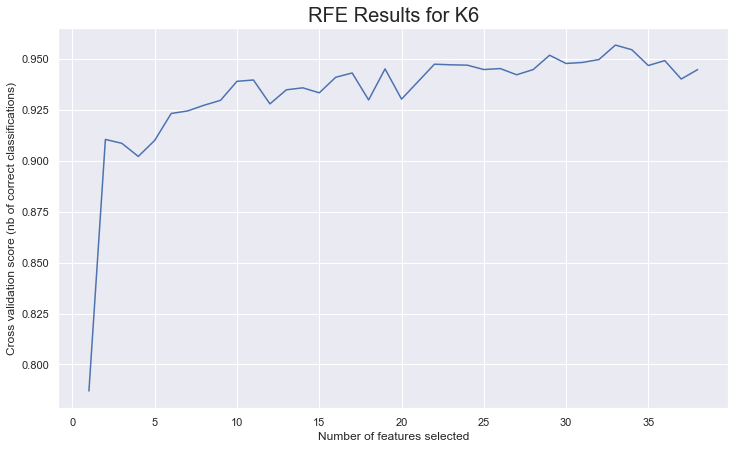

In [62]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for K6', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am going to include all features.

In [63]:
best_features_train = x_train.copy()
best_features_test = x_test.copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [64]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.6054279749478079
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6688
           1       0.92      0.45      0.61       321

    accuracy                           0.97      7009
   macro avg       0.95      0.72      0.80      7009
weighted avg       0.97      0.97      0.97      7009

[[6675   13]
 [ 176  145]] 

LogisticRegression F1:  0.6465028355387523
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6688
           1       0.82      0.53      0.65       321

    accuracy                           0.97      7009
   macro avg       0.90      0.76      0.82      7009
weighted avg       0.97      0.97      0.97      7009

[[6651   37]
 [ 150  171]] 

XGBClassifier F1:  0.6600790513833993
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6688
           1       0.90      0.52      0.66       3

In [65]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

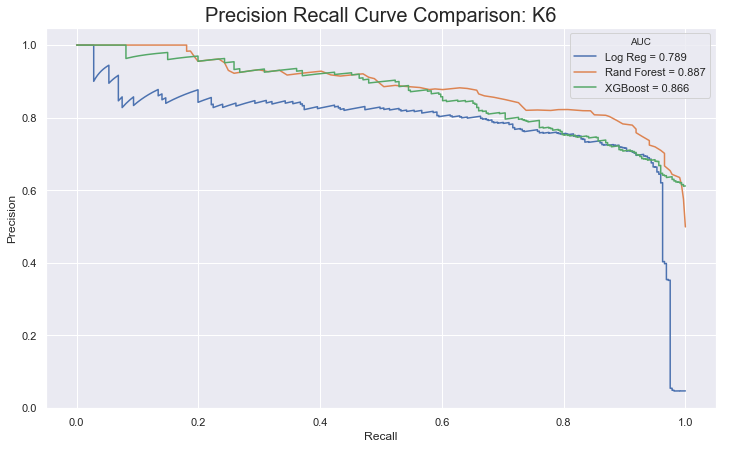

In [66]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: K6', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results

## PB3
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [67]:
PB3_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
PB3_chl_int_df = PB3_chl_int_df.drop(columns=['Lat', 'Long'])
PB3_chl_int_df = PB3_chl_int_df[chl_class_df['Sampling Location'] != 'PB3']

features = PB3_chl_int_df.iloc[:, :38].copy()
target = PB3_chl_int_df.loc[:, 'PB3_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_PB3_df = balance(PB3_chl_int_df, 'PB3')

x_train = balanced_PB3_df.iloc[:, :38]
target_train = balanced_PB3_df.loc[:, 'PB3_fail_overlap_chl']

## Feature Selection

In [68]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

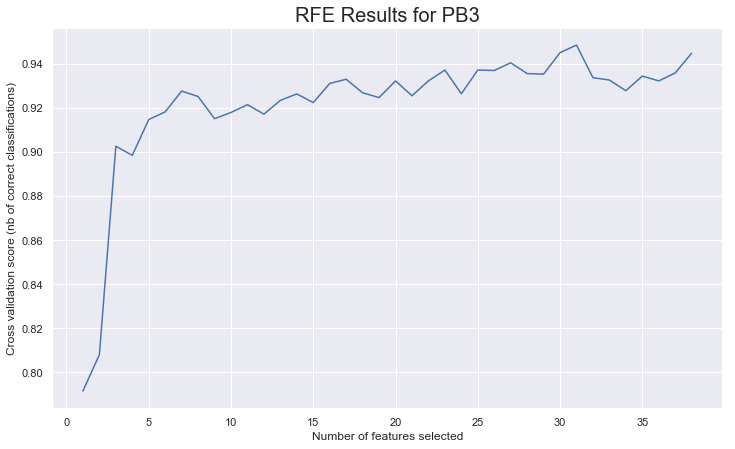

In [69]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('RFE Results for PB3', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am not going to drop any.

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [70]:
best_features_train = x_train
best_features_test = x_test

rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.7000000000000001
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6770
           1       0.81      0.62      0.70       284

    accuracy                           0.98      7054
   macro avg       0.90      0.81      0.84      7054
weighted avg       0.98      0.98      0.98      7054

[[6729   41]
 [ 109  175]] 



C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression F1:  0.7224080267558527
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6770
           1       0.69      0.76      0.72       284

    accuracy                           0.98      7054
   macro avg       0.84      0.87      0.86      7054
weighted avg       0.98      0.98      0.98      7054

[[6672   98]
 [  68  216]] 

XGBClassifier F1:  0.7303370786516854
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6770
           1       0.78      0.69      0.73       284

    accuracy                           0.98      7054
   macro avg       0.88      0.84      0.86      7054
weighted avg       0.98      0.98      0.98      7054

[[6715   55]
 [  89  195]] 



In [71]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

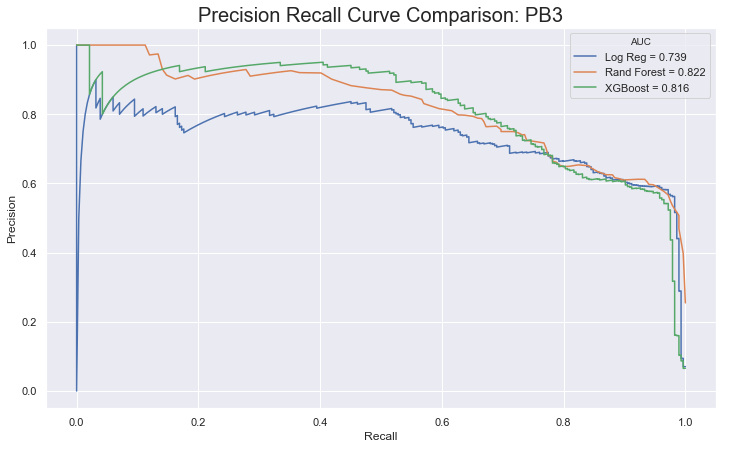

In [72]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison: PB3', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results

Of these models, XGBoost is the best classifier, but they all were very effective at predicting.

# Hyperparameter Tuning

First I'm going to create a baseline model to work with before tuning to determine the optimum number of trees for the learning rate.

In [73]:
param_grid = {'min_child_weight':[1, 5],
              'max_depth':[3, 6, 9],
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                            subsample=0.8, colsample_bytree=0.8)

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='precision')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 6, 9], 'min_child_weight': [1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [74]:
gscv.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [75]:
param_grid = {'gamma':[i/10 for i in range(0,5)]}
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0,
                             subsample=0.8, colsample_bytree=0.8,
                             max_depth=9, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='precision')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='pre

In [76]:
gscv.best_params_

{'gamma': 0.1}

In [77]:
param_grid = {'subsample':[i/10 for i in range(6,10)],
              'colsample_bytree':[i/10 for i in range(6,10)]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0.1,
                             max_depth=9, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='f1')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs',

In [78]:
gscv.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.9}

In [79]:
param_grid = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
             }
xg_model = xgb.XGBClassifier(learning_rate=0.1, gamma=0.1,
                             subsample=0.9, colsample_bytree=0.6,
                             max_depth=9, min_child_weight=1
                            )

gscv = GridSearchCV(xg_model, param_grid, cv=5, scoring='precision')

gscv.fit(best_features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [80]:
gscv.best_params_

{'reg_alpha': 0.005}

In [81]:
xg_model = xgb.XGBClassifier(learning_rate=0.01, gamma=0,
                             subsample=0.9, colsample_bytree=0.6,
                             max_depth=6, min_child_weight=1,
                             reg_alpha=0.005, n_estimators=1000
                            )

xg_model.fit(best_features_train, target_train)
target_pred = xg_model.predict(best_features_test)
probs = xg_model.predict_proba(best_features_test)
print(name, 'F1: ', f1_score(target_test, target_pred))
print(classification_report(target_test, target_pred))
print(confusion_matrix(target_test, target_pred), '\n')

XGBClassifier F1:  0.7554671968190855
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6770
           1       0.87      0.67      0.76       284

    accuracy                           0.98      7054
   macro avg       0.93      0.83      0.87      7054
weighted avg       0.98      0.98      0.98      7054

[[6741   29]
 [  94  190]] 



# Takeaways

- **Out of the box, XGBoost is best model for chlorophyll.** Consistently outperforming Random Forest Classifier and Logistic Regression models, XGBoost gave the highest precision which is the most important consideration. False positives cost the regulatory agencies money to perform more testing which defeats the purpose of the modeling in the first place.
- **Hyperparameter tuning improves model.** Using Grid Search Cross Validation to select hyperparameter values increases the precision of the XGBoost models. Particularly with the model developed for J8 improved from 0.85 to 0.96.
- **Ortho-Phosphorus matters** Ortho-Phosphorus Failure was consistently the most or one of the most highly correlated feature with high chlorophyll levels at different sites. Perhaps using this test as a preliminary measurement and then depending on whether the reading counts as a pass or fail, then it would be worth looking at other sites.
- **A lot of features are not important.** The redundancies in measured parameters are unnecessary. Most are colinear so they do not add to the model, and there are also ones that have no impact on the target variable.
- **Sites have different abilities to be predicted.** When building these models, there were certain sites that were not very predictable for one reason or another. 

# Future Research

- **Expand modeling to every site.** It would be worthwhile to run this process on every single site in the network. This would give an even more complete picture of the water system. Due to time constraints, I had to be selective with which sites I tested, but if it was not an issue, I could be even more thorough.
- **Expand modeling to other parameters.** There are EPA standards for a variety of parameters such as bacteria, dissolved oxygen, phosphorus and many more. Going through this process for each of those could also prove valuable to improving poor water quality detection and reducing monitoring costs.
- **Change the date range.** I looked at data from the past 20 years to capture weather abnormalities that may not repeat yearly but rather on a larger cycle like 5 or 10 years. Shrinking the range to 5 years may give more accurate models.
- **Develop a way to incorporate physical connectivity** This could be an entirely separate analysis, but by running experiments on the flow of water within this system would provide incredibly valuable information on how pollutants travel throughout the system. This would in turn greatly improve the modeling.